In [1]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.patterns import pattern_from_file_sequence
import pandas as pd
import aiohttp #Is auth still done this way?
import os

In [2]:
#move auth to correct place
os.environ['GPM_IMERG_USERNAME'] = 'alex@developmentseed.org'
os.environ['GPM_IMERG_PASSWORD'] = 'alex@developmentseed.org'

In [3]:
# Figure out the average file size for estimating files per chunk
import xarray as xr

ds = xr.open_dataset("../../data/3B-HHR.MS.MRG.3IMERG.20210303-S040000-E042959.0240.V06B.HDF5", group="Grid")
ds


<xarray.Dataset>
Dimensions:                         (lat: 1800, latv: 2, lon: 3600, lonv: 2, nv: 2, time: 1)
Coordinates:
  * time                            (time) object 2021-03-03 04:00:00
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
Dimensions without coordinates: latv, lonv, nv
Data variables: (12/13)
    time_bnds                       (time, nv) object ...
    lon_bnds                        (lon, lonv) float32 ...
    lat_bnds                        (lat, latv) float32 ...
    precipitationCal                (time, lon, lat) float32 ...
    precipitationUncal              (time, lon, lat) float32 ...
    randomError                     (time, lon, lat) float32 ...
    ...                              ...
    HQprecipSource                  (time, lon, lat) float32 ...
    HQobservationTime               (time, lon, lat) timedelta64[ns] ...
    IRprecipitation                 (time, lon, lat) float32 ...
    IRkalmanFilterWeight            (time, lon, lat) float32 ...
    probabilityLiquidPrecipitation  (time, lon, lat) float32 ...
    precipitationQualityIndex       (time, lon, lat) float32 ...
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

In [4]:
print(f"File size is {ds.nbytes/1e6} MB")

File size is 285.184824 MB


In [5]:
#url example
# https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2021/04/30/imerg/3B-HHR.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06B.HDF5
# Login is via the PPS system, username/password is the email address you register with
input_url_pattern = (
    "https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/{yyyy}/{mm}/{dd}/imerg/3B-HHR.MS.MRG.3IMERG.{yyyymmdd}-S{sh}{sm}00-E{eh}{em}59.{MMMM}.V06B.HDF5"
)

In [6]:
#June 2000 to 
dates = pd.date_range("2000-06-01T00:00:00", "2021-05-31T23:59:59", freq="30min")
input_urls = [
    input_url_pattern.format(
        yyyy=hhr.strftime("%Y"),
        mm = hhr.strftime("%m"),
        dd = hhr.strftime("%d"),
        yyyymmdd=hhr.strftime("%Y%m%d"),
        sh = hhr.strftime("%H"),
        sm = hhr.strftime("%M"),
        eh = hhr.strftime("%H"),
        em = (hhr+pd.Timedelta("29 min")).strftime("%M"),
        MMMM = f'{(hhr.hour*60 + hhr.minute):04}'
    )
    for hhr in dates
]
print(f"Found {len(input_urls)} files!")
input_urls[-1001]


Found 368160 files!


'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2021/05/11/imerg/3B-HHR.MS.MRG.3IMERG.20210511-S033000-E035959.0210.V06B.HDF5'

In [7]:
pattern = pattern_from_file_sequence(input_urls, "time", nitems_per_file=1)
pattern

<FilePattern {'time': 368160}>

In [9]:
for key in pattern:
    break
key

(DimIndex(name='time', index=0, sequence_len=368160, operation=<CombineOp.CONCAT: 2>))

In [10]:
pattern[key]

'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'

In [11]:
recipe = XarrayZarrRecipe(
    pattern, 
    xarray_open_kwargs={'group': 'Grid', 'drop_variables': ['time_bnds', 'lon_bnds', 'lat_bnds']},
    fsspec_open_kwargs={'client_kwargs':{'auth': aiohttp.BasicAuth(os.environ['GPM_IMERG_USERNAME'], os.environ['GPM_IMERG_PASSWORD'])},
                       'block_size':0},
    #fsspec_open_kwargs={'username': os.environ['GPM_IMERG_USERNAME'], 'password': os.environ['GPM_IMERG_PASSWORD']},
    inputs_per_chunk=1
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 368160}>, inputs_per_chunk=1, target_chunks={}, target=None, input_cache=None, metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, xarray_open_kwargs={'group': 'Grid', 'drop_variables': ['time_bnds', 'lon_bnds', 'lat_bnds']}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={'client_kwargs': {'auth': BasicAuth(login='alex@developmentseed.org', password='alex@developmentseed.org', encoding='latin1')}, 'block_size': 0}, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, is_opendap=False)

In [12]:
# Testing
import logging
logger = logging.getLogger("pangeo_forge_recipes")
formatter = logging.Formatter('%(name)s:%(levelname)s - %(message)s')
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
handler.setFormatter(formatter)
logger.setLevel(logging.INFO)
logger.addHandler(handler)

In [13]:
all_inputs = list(recipe.iter_inputs())
len(all_inputs)

368160

In [14]:
all_chunks = list(recipe.iter_chunks())
len(all_chunks)

368160

In [14]:
# wont' work until data is cached
#%xmode minimal
#with recipe.open_chunk(all_chunks[0]) as ds:
#    display(ds)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' directly.


Exception reporting mode: Minimal


ClientResponseError: 401, message='Unauthorized', url=URL('https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5')

In [43]:
all_chunks[1]

(DimIndex(name='time', index=1, sequence_len=368160, operation=<CombineOp.CONCAT: 2>))

In [15]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 368160}>, inputs_per_chunk=1, target_chunks={}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f414419c400>, root_path='/tmp/tmp0dws15jb'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f414419c400>, root_path='/tmp/tmp3owdikvy'), metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, xarray_open_kwargs={'group': 'Grid', 'drop_variables': ['time_bnds', 'lon_bnds', 'lat_bnds']}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={'client_kwargs': {'auth': BasicAuth(login='alex@developmentseed.org', password='alex@developmentseed.org', encoding='latin1')}, 'block_size': 0}, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, is_opendap=False)

In [23]:
for input_file in recipe.inputs_for_chunk(all_chunks[100000]):
    recipe.cache_input(input_file)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-100000'
pangeo_forge_recipes.storage:INFO - Caching file 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2006/02/13/imerg/3B-HHR.MS.MRG.3IMERG.20060213-S080000-E082959.0480.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Coping remote file 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2006/02/13/imerg/3B-HHR.MS.MRG.3IMERG.20060213-S080000-E082959.0480.V06B.HDF5' to cache


In [24]:
with recipe.open_chunk(all_chunks[100000]) as ds:
    display(ds)
    # need to load if we want to access the data outside of the context
    ds.load()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-100000
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-100000: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2006/02/13/imerg/3B-HHR.MS.MRG.3IMERG.20060213-S080000-E082959.0480.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2006/02/13/imerg/3B-HHR.MS.MRG.3IMERG.20060213-S080000-E082959.0480.V06B.HDF5' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-100000'


<xarray.Dataset>
Dimensions:                         (lat: 1800, lon: 3600, time: 1)
Coordinates:
  * time                            (time) object 2006-02-13 08:00:00
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
Data variables:
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

In [25]:
print(f'Total chunk size: {ds.nbytes / 1e6} MB')

Total chunk size: 285.141608 MB


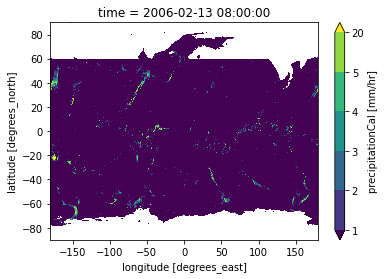

In [29]:
ds.transpose('time', 'lat', 'lon').precipitationCal.plot(levels=[1,2,3,4,5,20])

In [30]:
recipe.prepare_target()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Creating a new dataset in target
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing dataset in /tmp/tmp0dws15jb
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Expanding target concat dim 'time' to size 368160


In [31]:
import zarr
zgroup = zarr.open(target_dir.name)
print(zgroup.tree())

/
 ├── HQobservationTime (368160, 3600, 1800) float64
 ├── HQprecipSource (368160, 3600, 1800) float32
 ├── HQprecipitation (368160, 3600, 1800) float32
 ├── IRkalmanFilterWeight (368160, 3600, 1800) float32
 ├── IRprecipitation (368160, 3600, 1800) float32
 ├── lat (1800,) float32
 ├── lon (3600,) float32
 ├── precipitationCal (368160, 3600, 1800) float32
 ├── precipitationQualityIndex (368160, 3600, 1800) float32
 ├── precipitationUncal (368160, 3600, 1800) float32
 ├── probabilityLiquidPrecipitation (368160, 3600, 1800) float32
 ├── randomError (368160, 3600, 1800) float32
 └── time (368160,) int64


In [32]:
zgroup['precipitationCal'].info

Name,/precipitationCal
Type,zarr.core.Array
Data type,float32
Shape,"(368160, 3600, 1800)"
Chunk shape,"(1, 3600, 1800)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,9542707200000 (8.7T)
No. bytes stored,572


In [33]:
recipe.store_chunk(all_chunks[0])
zgroup['precipitationCal'].info

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable time chunk time-0 to Zarr region (slice(0, 1, None),)
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable precipitationCal chunk time-0 to Zarr region (slice(0, 1, None), slice(None, None, None), slice(None, None, None))
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable precipitationUncal chunk time-0 to Zarr region (slice(0, 1, None), slice(

Name,/precipitationCal
Type,zarr.core.Array
Data type,float32
Shape,"(368160, 3600, 1800)"
Chunk shape,"(1, 3600, 1800)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,9542707200000 (8.7T)
No. bytes stored,4449565 (4.2M)


285141608